In [1]:
import os
from typing import Dict, List, Optional, Any, Literal

# Tavily API
from tavily import TavilyClient

# Langchain
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage, ToolMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_classic.text_splitter import RecursiveCharacterTextSplitter
from langchain_core.documents import Document

# LangChain Anthropic
from langchain_anthropic import ChatAnthropic

# Langgraph
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph.state import CompiledStateGraph
from langgraph.types import interrupt, Command

# Evaluation 
from ragas import EvaluationDataset
from ragas import evaluate
from ragas.llms import llm_factory
from ragas.metrics.collections import Faithfulness, FactualCorrectness, ToolCallAccuracy, SemanticSimilarity
from ragas import messages as ragas_messages
from ragas.integrations.langgraph import convert_to_ragas_messages
from ragas.dataset_schema import MultiTurnSample

# Anthropic
from anthropic import Anthropic, AsyncAnthropic

#OpenAI
from openai import OpenAI, AsyncOpenAI

# Environment Variables
from dotenv import load_dotenv
from IPython.display import Image, display

# langfuse
from langfuse import get_client, observe
from langfuse.langchain import CallbackHandler

# Database Imports
from langchain_classic.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings

#Extra imports
import uuid

#local Imports
#import healthbot_state
#import functions

/Users/rmiles/Desktop/local_projects/Projects/Healthbot/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
load_dotenv("config.env")
langfuse = get_client()
langfuse_handler = CallbackHandler()
tavily_client = TavilyClient()

# Instantiate our models

In [3]:
base_llm = ChatOpenAI(
    model="gpt-5.1",
    temperature=0.0
)

small_llm = ChatOpenAI(
    model = "gpt-4o-mini",
    temperature = 0.0
)

quiz_grader = ChatAnthropic(
    model="claude-sonnet-4-5-20250929",
    temperature=0.1,
    )

# Create and define our tools and llm with tools

In [4]:
@tool
@observe(as_type="tool", capture_input=True, capture_output=True)
def web_search(question:str)->Dict:
    """
    Return top search results for a given search query.
    """
    response = tavily_client.search(
        query=question,
        topic="general",
        max_results=4,
        include_domains=["https://www.webmd.com","https://medlineplus.gov","https://www.health.harvard.edu","https://www.mayoclinic.org"])
    return response

In [ ]:
# Function to format the documents that are the output of the tavily tool.
@tool
def create_docs(docs) -> list:
    """This tool is used to get the information from tool outputs and format the info to be used in llm inputs."""
    pages = docs.get('results')
    request_id = docs.get('request_id')
    documents = []
    ids = []

    for page in range(len(pages)):
        id = uuid.uuid4()
        ids.append(id)
        documents.append(Document(
            page_content=pages[page].get('content'),
            metadata={'id':id,'source':pages[page].get('url'), 'title':pages[page].get('title'), 'request_id': request_id}
            ))
    return [documents, ids]

In [ ]:
#Formatting function needs to also be a tool maybe, added to the list here
tools = [web_search, create_docs]

In [5]:
tools = [web_search]

In [6]:
llm_with_tools = small_llm.bind_tools(tools)

# State Schema

In [7]:
class State(MessagesState):
    topic: Optional[str]                        # This is the input topic gathered from the user
    documents: List[Document]                  # List of documents; documents to be added to the vector DB, gather from formatting function
                                                    # These docs will become the last message from invoking the model.
    summary: Optional[str]                     # Once docs are stored in the vDB, we can use RAG to generate the required summary
    quiz_question: Optional[str]               # maybe a nested langchain process to invoke our RAG system or we attach RAG as a tool
    patient_answer: Optional[str]
    quiz_grade: Optional[Dict[str, Any]]
    phase: Optional[
        Literal[
            "ask_topic",
            "searching",
            "show_summary",
            "waiting_ready",
            "quiz_generated",
            "waiting_answer",
            "evaluated",
            "waiting_restart"
        ]
    ]
    repeat_mode: bool

# Create the Nodes/Agents/routers

### Create the entrypoint node

 - introduce the application
 - For later development:
     - maybe record the workflow beginning with a DB entry to record that patient X is attempting the application

In [8]:
def entrypoint(state: State)->State:
    print("Hi Im the Healthbot Assistant, here to help you understand your post treatment care instructions.\n")
    sys_message = SystemMessage(
        content=(
            "You are the Healthbot Assistant. You are required to conduct a web search and gather relevant documents that pertain to "
            "the users topic of interest."
        )
    )
    ai_message = AIMessage(
        content=(
            "What health topic or medical condition do you want to learn about?"
        )
    )
    messages = state['messages'] + [sys_message, ai_message]
   
    return {"messages": messages, "phase": "ask_topic", "documents": None, "summary":None, "quiz_question":None, "patient_answer": None, "quiz_grade": None, "repeat_mode":False}

In [9]:
def info_agent(state: State):
    raw_topic = interrupt("What topic do you want to learn about? ")
    topic = raw_topic.get("topic")

    messages = state["messages"]
    messages.append(raw_topic["messages"])
    ai_message = llm_with_tools.invoke(messages)

    messages.append(ai_message)

    return {"topic": topic, "messages": messages, "phase": "searching"}

In [ ]:
def format_agent(state: State):
    messages = state["messages"]
    sys_message = SystemMessage(content="Use a tool to format these messages. Do nothing else.")
    quick_messages = [sys_message, messages[-1]]
    docs = llm_with_tools.invoke(quick_messages)
    messages += [quick_messages, docs.content[0]]
    
    return {"documents":docs.content[0]}


In [10]:
# If our info_agent's last message is a tool call, go to tools. If its not, go back to the entrypoint.
def router_1(state: State):
    last_message = state["messages"][-1]
    if last_message.tool_calls:
        return "tools"
    return "entrypoint"

In [11]:
def summary_agent(state: State):
    messages = state["messages"]
    last_message = state["messages"][-1].content_blocks[0]['text']
    topic = state["topic"]

    sys_message = SystemMessage(
            content = (
                f"The user is looking to learn about post treatment care for '{topic}'. The provided information is \n\n>>{last_message}."
                "\n\nSummarize the information provided, providing the post treatment care instructions to the user. Do not ask for more info. "
                "Do not make any other recomendations, do not offer to follow up. Your only instruction and task is to provide this summary for the user."
            )
        )
    
    summary = small_llm.invoke([sys_message])
    messages += [summary] 
    

    return{"messages": messages, "summary": summary.content, "phase": "show_summary"}

In [12]:
def quiz_agent(state: State):
    summary = state["summary"]
    messages = state["messages"]

    quiz_sys_message = SystemMessage(
        content=(f"Analyze the following summary:"
        f"\n\n>> {summary}"
        "\n\nGenerate an open-ended quiz for a patient. The quiz should only be one question."
        "\nMake this quiz question level 1 difficulty on a scale of 0 to 5. "
        "\n0 = kindergaten level difficulty. 5 = highschool level diffuculty. " \
        "\nThis quiz question should be based only on the summary provided." \
        "\nThis quiz question will be presented to a patient. Its your goal to help the patient understand their post treatment care provided in the summary. " \
        "\nOnly generate the described one quiz question, nothing else." ))
    
    quiz_question = small_llm.invoke([quiz_sys_message]) 
    
    messages = messages + [quiz_sys_message, quiz_question]

    return {"messages": messages, "quiz_question": quiz_question.content, "phase": "quiz_generated"}

In [20]:
async def quiz_grader_agent(state: State):
    
    patient_answer = interrupt("Please answer the quiz question: ")
    
    client = AsyncOpenAI()
    messages = state["messages"]
    summary = state["summary"]
    quiz_question = state["quiz_question"]
    
    evaluator_llm = llm_factory(model="gpt-5-nano", provider="openai", client=client, max_tokens=1000)

    scorer = Faithfulness(llm=evaluator_llm)

    result = await scorer.ascore(
        user_input = quiz_question, 
        response = patient_answer.get("patient_answer"), 
        retrieved_contexts = [summary])

    result_str = str(result)

    prompt_template = ChatPromptTemplate.from_messages([
            ("system", "You generated a summary of post treatment care for a patient. Then you created a quiz for the patient."
            "\nThis is the quiz: \n>>{quiz_question}. "
            "\n\nThe patient provided this answer to the quiz:\n{patient_answer}"
            "\nThe patients answer had a faithfullness score of {result} to the quiz question."
            "\nThe value of the faithfullness score is on a range between 0 and 1. anything that is a 0.65 and below is an F. Anything above a 0.65 "
            "up to a 0.8 is a C. Anything above a 0.8 up to a 0.9 is a B and anything above a 0.9 is an A."
            "\n\nTranslate the patients score to a letter grading. Output only, 'A', 'B', 'C', or 'F' based on the score. Do not output anything else. "),
            ("human","What did I make on the quiz?")])

    ai_message = prompt_template.invoke({
        "patient_answer": patient_answer,
        "quiz_question": quiz_question, 
        "result": result_str,
    })

    quiz_grade = await small_llm.ainvoke(ai_message.to_messages())

    messages.append([patient_answer.get("messages"), ai_message.to_messages(), quiz_grade])

    print(quiz_grade.content)
    
    return {"mesages": messages, "patient_answer": patient_answer, "quiz_grade": quiz_grade.content, "phase": "evaluated"}


In [14]:
def router_2(state: State):
    repeat_mode = state["repeat_mode"]
    if repeat_mode:
        return "quiz_agent"
    return END

# Compile our graph

In [21]:
workflow = StateGraph(State)

workflow.add_node("entrypoint", entrypoint)
workflow.add_node("info_agent", info_agent)
#workflow.add_node("format_agent", format_agent)
workflow.add_node("tools", ToolNode(tools))
workflow.add_node("summary_agent", summary_agent)
workflow.add_node("quiz_agent", quiz_agent)
workflow.add_node("quiz_grader_agent", quiz_grader_agent)

workflow.add_edge(START, "entrypoint")
workflow.add_edge("entrypoint", "info_agent")

workflow.add_conditional_edges(
    source = "info_agent",
    path = router_1,
    path_map = ["tools", "entrypoint"]
)

#workflow.add_edge("tools", "info_agent")

workflow.add_edge("tools", "summary_agent")
workflow.add_edge("summary_agent", "quiz_agent")
workflow.add_edge("quiz_agent", "quiz_grader_agent")

workflow.add_conditional_edges(
    source="quiz_grader_agent",
    path=router_2,
    path_map=["quiz_agent", END]
)

workflow.add_edge("quiz_grader_agent", END)


In [22]:
memory = MemorySaver()
graph = workflow.compile(
    checkpointer = memory
)

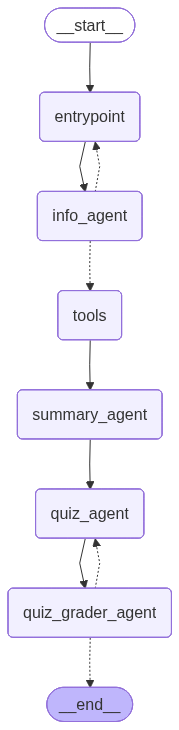

In [17]:
display(
    Image(
        graph.get_graph().draw_mermaid_png()
    )
)

# Create the function that runs the application

 - This is a human in the loop interaction workflow.

In [23]:
async def hitl_interaction_flow(graph: CompiledStateGraph, thread_id: int): 
    
    config = {"configurable": {"thread_id": thread_id}, 
              "callbacks": [langfuse_handler],
              "metadata":{
                  "session_id": str(thread_id),
                  "app": "Healthbot",
              }}

    #restart_from = graph.get_state(config)     #store a checkpoint from this step
    async def run_until_interrupt_or_end(resume_payload=None):
        stream_input = Command(resume=resume_payload) if resume_payload is not None else {}

        async for update in graph.astream(stream_input, config=config, stream_mode="updates"):
            for _, node_out in update.items():
                if isinstance(node_out, dict) and node_out.get("messages"):
                    node_out["messages"][-1].pretty_print()
            
            if "__interrupt__" in update:
                return update["__interrupt__"]
            if "interrupt" in update:
                return update["interrupt"]
        return None
        
    interrupt_payload = await run_until_interrupt_or_end()
    if interrupt_payload is None:
        return
    
    human_input_topic = input("Please input what post treatment topic you'd like to learn about: ").strip()
    resume_1 = {
        "topic": human_input_topic,
        "messages": HumanMessage(content=human_input_topic)
    }

    interrupt_payload = await run_until_interrupt_or_end(resume_payload=resume_1)
    if interrupt_payload is None:
        return  # graph ended early (quiz interrupt never happened)

    quiz_answer_input = input("Please provide an answer to the quiz below:\n>> ").strip()
    resume_2 = {
        "patient_answer": quiz_answer_input,
        "messages": HumanMessage(content=quiz_answer_input)
    }

    await run_until_interrupt_or_end(resume_payload=resume_2)

# Testing the Healthbot

In [24]:
h = await hitl_interaction_flow(
    graph=graph,
    thread_id=1
    )

Hi Im the Healthbot Assistant, here to help you understand your post treatment care instructions.

================================== Ai Message ==================================

What health topic or medical condition do you want to learn about?
================================== Ai Message ==================================
Tool Calls:
  web_search (call_sGKH8Vt0AEdxmc5MBSGtoWuh)
 Call ID: call_sGKH8Vt0AEdxmc5MBSGtoWuh
  Args:
    question: COPD (Chronic Obstructive Pulmonary Disease) information, symptoms, treatment, and management
================================= Tool Message =================================
Name: web_search

{"query": "COPD (Chronic Obstructive Pulmonary Disease) information, symptoms, treatment, and management", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://medlineplus.gov/copd.html", "title": "COPD | Chronic Obstructive Pulmonary Disease - MedlinePlus", "content": "COPD (chronic obstructive pulmonary disease) is a gro